In [50]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad

from matplotlib import cm  # colormaps
from matplotlib.colors import Normalize

kappa = 3 / 4 * 0.0224 / (2.469*10**(-5)) # omega_b / 2.469*10**(-5)

def integral_trapezoid(func, a, b, N, H0, omega_m):
    h = (b - a) / N
    result = 0.5 * (func(a, H0, omega_m) + func(b, H0, omega_m))
    for i in range(1, N):
        result += func(a + i * h, H0, omega_m)
    result *= h
    return result

def H_LCDM(z, H0, omega_m):
    return H0 * np.sqrt(omega_m * (1+z)**3 + (1 - omega_m))

def inv_H_LCDM(z, H0, omega_m):
    return 1.0 / H_LCDM(z, H0, omega_m)

def cs_H(z, H0, omega_m):
    z_shifted = z + 1
    result = np.sqrt((z_shifted + kappa) * (omega_m * z_shifted**2 + (1 - omega_m) / z_shifted))
    return 1.0 / result

def alpha(omega_m, H0, sup, N):
    frac_planck = 20.38
    z = 0.851

    I1 = integral_trapezoid(inv_H_LCDM, 0.0, z, 100, H0, omega_m)
    I2 = integral_trapezoid(cs_H, z, sup, N, H0, omega_m)
    return np.sqrt(3) * H0 * I1 / I2

Valeur de référence de α (quad) = 3.0964302588


/tmp/ipykernel_4018/3433027756.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


Pour sup=950.0, Minimum = 0.0005550678429623502 en N=600
Pour sup=952.5, Minimum = 0.0007981287285732478 en N=700
Pour sup=955.0, Minimum = 0.00047932129589457864 en N=700
Pour sup=957.5, Minimum = 0.0001616442558810548 en N=700
Pour sup=960.0, Minimum = 0.00015491000719556288 en N=700
Pour sup=962.5, Minimum = 0.00047034903975707356 en N=700
Pour sup=965.0, Minimum = 0.0003348376040761876 en N=800
Pour sup=967.5, Minimum = 2.6738016567421694e-05 en N=800
Pour sup=970.0, Minimum = 0.00028025862294533895 en N=800
Pour sup=972.5, Minimum = 0.0001924366212171065 en N=900
Pour sup=975.0, Minimum = 0.00010880948093757161 en N=900
Pour sup=977.5, Minimum = 0.00015276599050925507 en N=1000
Pour sup=980.0, Minimum = 0.0001437397923959772 en N=1000
Pour sup=982.5, Minimum = 2.0168240760594743e-05 en N=1100
Pour sup=985.0, Minimum = 7.144185184294592e-06 en N=1200
Pour sup=987.5, Minimum = 3.3093998852784226e-05 en N=1300
Pour sup=990.0, Minimum = 3.8178010103120786e-05 en N=1500
Pour sup=992.5,

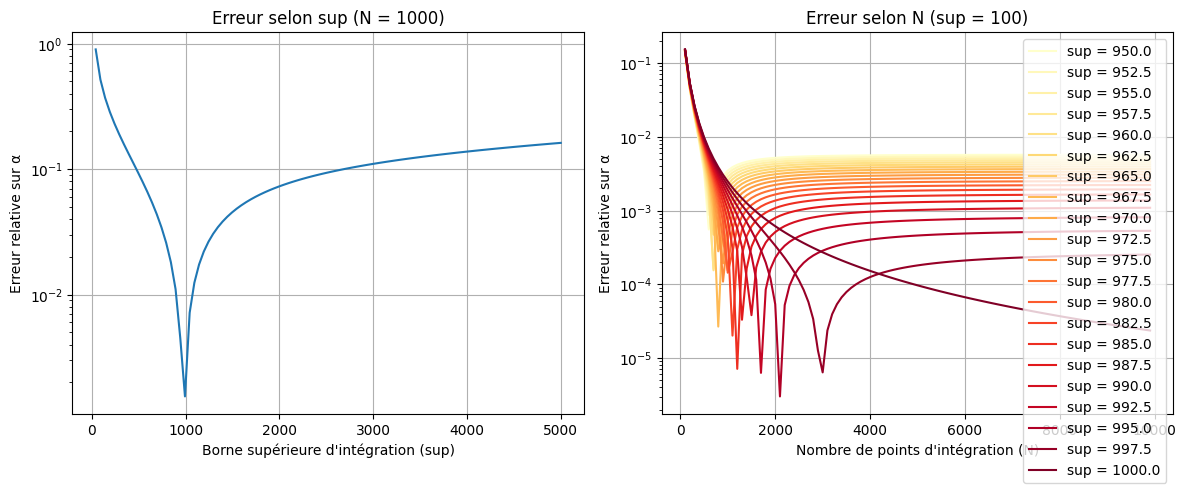

In [51]:
H0 = 67  # km/s/Mpc (Planck 2018)
omega_m = 0.35
z = 0.851
I1_ref, _ = quad(lambda z: inv_H_LCDM(z, H0, omega_m), 0.0, z)
I2_ref, _ = quad(lambda z: cs_H(z, H0, omega_m), z, 1000)
alpha_ref = np.sqrt(3) * H0 * I1_ref / I2_ref

print(f"Valeur de référence de α (quad) = {alpha_ref:.10f}")

N_fixed = 1000
sup_values = np.linspace(40, 5000, 100)
alpha_sup = [alpha(omega_m, H0, sup, N_fixed) for sup in sup_values]
error_sup = [abs((a - alpha_ref) / alpha_ref) for a in alpha_sup]

sup_fixed = 100
N_values = np.arange(100, 10000, 100)
alpha_N = [alpha(omega_m, H0, sup_fixed, N) for N in N_values]
error_N = [abs((a - alpha_ref) / alpha_ref) for a in alpha_N]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sup_values, error_sup)
plt.yscale("log")
plt.xlabel("Borne supérieure d'intégration (sup)")
plt.ylabel("Erreur relative sur α")
plt.title(f"Erreur selon sup (N = {N_fixed})")
plt.grid(True)

N_values = np.arange(100, 10000, 100)
errors_N_multi = {}
# sup_test_vals = [500 + 100*i for i in range(20)]
sup_test_vals = [950 + 2.5*i for i in range(21)]
norm = Normalize(vmin=min(sup_test_vals), vmax=max(sup_test_vals))
cmap = cm.get_cmap("YlOrRd")
for sup_val in sup_test_vals:
    errors_N_multi[sup_val] = []
    minimum = [100,0]
    for N in N_values:
        a = alpha(omega_m, H0, sup_val, N)
        err = abs((a - alpha_ref) / alpha_ref)
        errors_N_multi[sup_val].append(err)
        if err < minimum[0]:
            minimum = [err, N]
    print(f"Pour sup={sup_val}, Minimum = {minimum[0]} en N={minimum[1]}")

plt.subplot(1, 2, 2)
for i, sup_val in enumerate(sup_test_vals):
    plt.plot(N_values, errors_N_multi[sup_val], color=cmap(norm(sup_val)), label=f"sup = {sup_val}")
plt.yscale("log")
plt.xlabel("Nombre de points d'intégration (N)")
plt.ylabel("Erreur relative sur α")
plt.title(f"Erreur selon N (sup = {sup_fixed})")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
from classy import Class

params = {
    'h': 0.674,
    'omega_b': 0.0224,
    'omega_cdm': 0.315 * 0.674**2 - 0.0224,
    'A_s': 2.1e-9,
    'n_s': 0.965,
    'tau_reio': 0.054,
    'output': 'mPk',
}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

z_eff = 0.851
DM = cosmo.angular_distance(z_eff) * (1 + z_eff)

rd = cosmo.rs_drag()
ratio = DM / rd
print(f"(D_M/r_d)_Planck = {ratio:.4f}")
cosmo.struct_cleanup()
cosmo.empty()


(D_M/r_d)_Planck = 20.5172
